In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("..")) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from models import kane_mele
from pythtb import *
from wanpy import *

In [3]:
# tight-binding parameters
onsite = 1.0  # 1.0 for top, 2.5 for triv
t = 1
soc = 0.6*t*0.5
rashba = 0.25*t

n_supercell = 2
model = kane_mele(onsite, t, soc, rashba).make_supercell([[n_supercell, 0], [0, n_supercell]])

#############

n_orb = model.get_num_orbitals()
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
n_occ = int(n_orb/2)*2
low_E_sites = list(np.arange(0, n_orb, 2))
high_E_sites = list(np.arange(1, n_orb, 2))

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")

Low energy sites: [np.int64(0), np.int64(2), np.int64(4), np.int64(6)]
High energy sites: [np.int64(1), np.int64(3), np.int64(5), np.int64(7)]


In [4]:
omit_sites = 6
tf_sites  = list(np.setdiff1d(low_E_sites, [omit_sites]))  # delta on lower energy sites omitting the last site
tf_list = [ [(orb, spin, 1) ] for orb in tf_sites for spin in [0,1] ]
n_tfs = len(tf_list)
Wan_frac = n_tfs/n_occ

model_name = "kane_mele"
model_str = f't={t}_soc={soc}_onsite={onsite}_n_occ={n_occ}'
save_sfx = model_str + f'_tfx={np.array(tf_sites, dtype=int)}'

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")
print(save_sfx)

Trial wavefunctions: [[(np.int64(0), 0, 1)], [(np.int64(0), 1, 1)], [(np.int64(2), 0, 1)], [(np.int64(2), 1, 1)], [(np.int64(4), 0, 1)], [(np.int64(4), 1, 1)]]
# of Wannier functions: 6
# of occupied bands: 8
Wannier fraction: 0.75
t=1_soc=0.3_onsite=1.0_n_occ=8_tfx=[0 2 4]


In [5]:
sv_dir = 'data'
sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

WF = np.load(f"{file_name}.npy", allow_pickle=True).item()

sv_prefix = 'WF_loc_steps'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

loc_steps = np.load(f"{file_name}.npy", allow_pickle=True).item()

In [6]:
for key, val in loc_steps.items():
    print(f"{key}: Omega = {sum(val['Omega'])/WF.n_twfs: .4f}")
    print(f"{key}: Omega_I = {val['Omega_i']/WF.n_twfs: .4f}")
    print(f"{key}: Omega_til = {val['Omega_til']/WF.n_twfs: .4f}")

P: Omega =  0.2680
P: Omega_I =  0.2305
P: Omega_til =  0.0375
P+ML: Omega =  0.2659
P+ML: Omega_I =  0.2305
P+ML: Omega_til =  0.0354
P+SS+P: Omega =  0.1991
P+SS+P: Omega_I =  0.1880
P+SS+P: Omega_til =  0.0112
P+SS+P+ML: Omega =  0.1979
P+SS+P+ML: Omega_I =  0.1880
P+SS+P+ML: Omega_til =  0.0100


[]

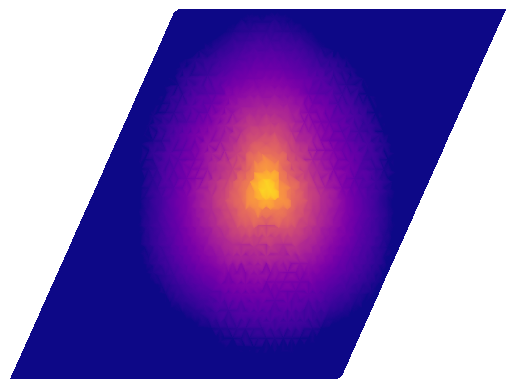

In [7]:
fig, ax = plot_density(WF, 0, show_lattice=False, lat_size=2, cbar=False, return_fig=True, interpolate=True)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])


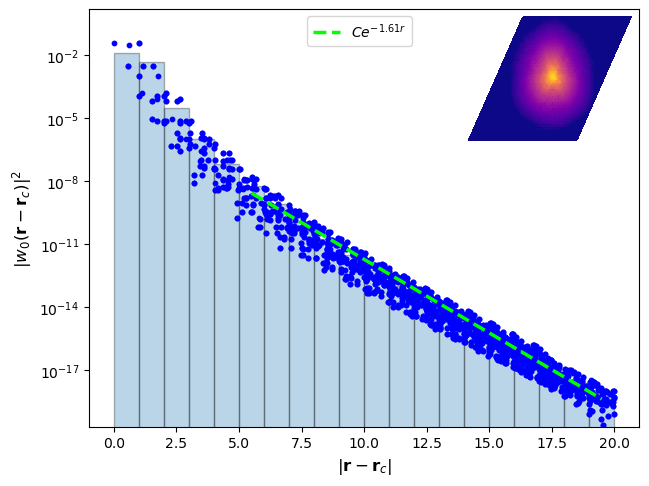

In [8]:
idx = 0
fig, ax = plot_decay(WF, idx, fit_rng=[5, 20], return_fig=True)
ax.legend(bbox_to_anchor=(0.6, 1.0))
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper right')  # You can adjust size and location
fig, inset_ax = plot_density(
    WF, idx, show_lattice=False, lat_size=2, cbar=False, interpolate=True, fig=fig, ax=inset_ax, return_fig=True)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.axis('off')
plt.subplots_adjust(top=0.98, left=0.12, bottom=0.11, right=0.98)
plt.savefig(f'figures/fig12_decay_and_dens_{save_sfx}.png', dpi=700)

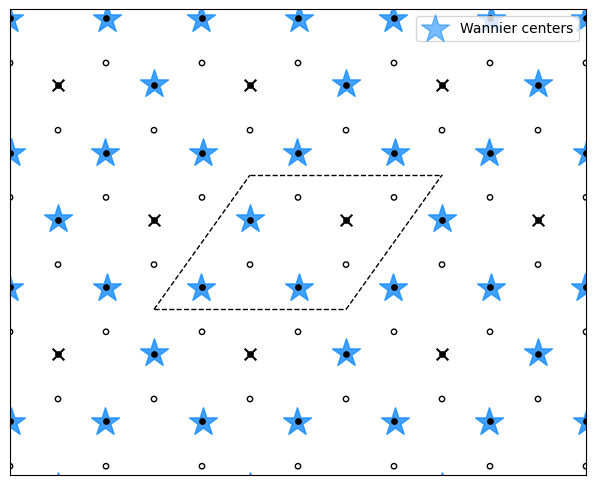

In [30]:
# title = (
#   "Haldane model \n"
#   fr"$C = {chern: .1f}$, $\Delta = {delta}$, $t= {t: .2f}, t_2 = {t2: .2f}$"
#   )

kwargs_centers = {'marker': '*', 'c': 'dodgerblue', 'alpha': 0.6} 
kwargs_omit = {'s': 70, 'marker': 'x', 'c': 'k', 'zorder': 3} 
kwargs_lat_ev = {'s': 15, 'marker': 'o', 'c': 'k'} 
kwargs_lat_odd = {'s': 15, 'marker': 'o', 'facecolors':'none', 'edgecolors':'k'} 


fig, ax = plot_centers(
    WF, title=None, center_scale=50, omit_sites=[omit_sites], section_home_cell=True, 
    color_home_cell=False, translate_centers=True, kwargs_centers=kwargs_centers, 
    kwargs_lat_ev=kwargs_lat_ev, kwargs_lat_odd=kwargs_lat_odd, kwargs_omit=kwargs_omit,
    pmx=3, pmy=3, legend=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('')

sv_dir = 'figures'
sv_prefix = 'Wan_centers'
file_name = f"{sv_dir}/fig12a_{sv_prefix}_{save_sfx}.png"

# plt.subplots_adjust(top=1, left=0, bottom=0, right=1)
plt.subplots_adjust(top=0.98, left=0.05, bottom=0.01, right=.95)

# plt.savefig(file_name, dpi=700)

In [31]:
WF.tilde_states.get_states()["Cell periodic"].shape

(20, 20, 6, 16)

In [32]:
u_tilde = WF.tilde_states.get_states(flatten_spin=False)["Cell periodic"]  # reduced tilde states
# P_tilde, Q_tilde = WF.tilde_states.get_projector(return_Q=True)  # tilde space projectors
P_tilde = np.einsum("...ni, ...nj -> ...ij", u_tilde, u_tilde.conj())  # occupied band projector
Q_tilde = np.eye(P_tilde.shape[-1]) - P_tilde  # occ complement

u_energy = WF.energy_eigstates.get_states(flatten_spin=True)["Cell periodic"]  # energy eigenstates
P, Q = WF.energy_eigstates.get_projector(return_Q=True)  # full band projector

u_occ = u_energy[..., :n_occ, :]  # occupied energy eigenstates
P_occ = np.einsum("...ni, ...nj -> ...ij", u_occ, u_occ.conj())  # occupied band projector
Q_occ = np.eye(P_occ.shape[-1]) - P_occ  # occ complement

## Projectors on full mesh
P_top = P_occ - P_tilde  # complementary subspace

eigvals, eigvecs = np.linalg.eigh(P_top)  # states spanning complement
u_top = eigvecs[..., :, -2:]  # take state with non-zero eigval
u_top = np.swapaxes(u_top, -1, -2)
P_comp = np.einsum("...ni, ...nj -> ...ij", u_top, u_top.conj())

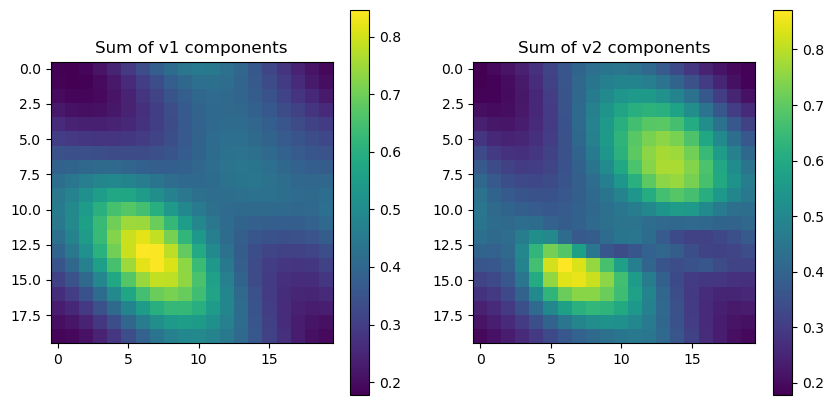

In [33]:
# Assume 'projectors' is your (20, 20, 16, 16) array
# projectors[i, j] is the 16x16 projector at grid point (i, j)

# Initialize arrays to store eigenvectors
v1 = np.zeros((20, 20, 16), dtype=complex)
v2 = np.zeros((20, 20, 16), dtype=complex)

# Step 1: Starting point (0, 0)
# Eigenvectors corresponding to eigenvalue 1 (last two, assuming sorted)
v1[0, 0] = eigvecs[0,0, :, -1]  # Adjust indices based on your eigenvalue ordering
v2[0, 0] = eigvecs[0,0, :, -2]

# Step 2: First row
for j in range(1, 20):
    P = P_top[0, j]
    # Align v1
    w1 = P @ v1[0, j-1]
    v1[0, j] = w1 / np.linalg.norm(w1)
    if np.dot(v1[0, j], v1[0, j-1]) < 0:
        v1[0, j] *= -1
    # Align v2
    w2 = P @ v2[0, j-1]
    w2 = w2 - np.dot(v1[0, j], w2) * v1[0, j]
    v2[0, j] = w2 / np.linalg.norm(w2)
    if np.dot(v2[0, j], v2[0, j-1]) < 0:
        v2[0, j] *= -1

# Step 3: Remaining rows
for i in range(1, 20):
    # First column point
    P = P_top[i, 0]
    w1 = P @ v1[i-1, 0]
    v1[i, 0] = w1 / np.linalg.norm(w1)
    if np.dot(v1[i, 0], v1[i-1, 0]) < 0:
        v1[i, 0] *= -1
    w2 = P @ v2[i-1, 0]
    w2 = w2 - np.dot(v1[i, 0], w2) * v1[i, 0]
    v2[i, 0] = w2 / np.linalg.norm(w2)
    if np.dot(v2[i, 0], v2[i-1, 0]) < 0:
        v2[i, 0] *= -1
    # Rest of the row
    for j in range(1, 20):
        P = P_top[i, j]
        w1 = P @ v1[i, j-1]
        v1[i, j] = w1 / np.linalg.norm(w1)
        if np.dot(v1[i, j], v1[i, j-1]) < 0:
            v1[i, j] *= -1
        w2 = P @ v2[i, j-1]
        w2 = w2 - np.dot(v1[i, j], w2) * v1[i, j]
        v2[i, j] = w2 / np.linalg.norm(w2)
        if np.dot(v2[i, j], v2[i, j-1]) < 0:
            v2[i, j] *= -1

# Compute sums
v1_ext = v1.reshape(20, 20, 8, 2)
v2_ext = v2.reshape(20, 20, 8, 2)
col_lat_1 = np.sum([ abs(v1_ext[..., i, :])**2 for i in high_E_sites], axis=(0,-1))
col_lat_2 = np.sum([ abs(v2_ext[..., i, :])**2 for i in high_E_sites], axis=(0,-1))

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(col_lat_1, cmap='viridis')
plt.title('Sum of v1 components')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(col_lat_2, cmap='viridis')
plt.title('Sum of v2 components')
plt.colorbar()
plt.show()

In [34]:
P_top.shape

(20, 20, 16, 16)

In [35]:
v1.shape

(20, 20, 16)

In [36]:
np.matmul(P_top[0,0], v2[0,0]) - v2[0,0]

array([-1.11022302e-16-1.73472348e-18j,  9.71445147e-17+6.93889390e-18j,
        1.38777878e-16-1.04083409e-17j,  1.38777878e-17-1.38777878e-17j,
       -9.71445147e-17-2.08166817e-17j,  6.93889390e-18+2.77555756e-17j,
       -8.32667268e-17-8.67361738e-19j, -6.93889390e-17+2.77555756e-17j,
       -5.55111512e-17+6.93889390e-18j, -1.38777878e-17+6.93889390e-18j,
       -8.32667268e-17+1.21430643e-17j, -2.77555756e-17-3.81639165e-17j,
        3.33066907e-16-1.38777878e-17j, -5.55111512e-17-1.11022302e-16j,
       -1.11022302e-16+2.08166817e-17j,  0.00000000e+00+5.55111512e-17j])

In [37]:
np.vdot(v1[0,0], v2[0,0])

np.complex128(-1.1102230246251565e-16+2.7755575615628914e-17j)

In [38]:
u_top = eigvecs[..., :, -2:]
u_top = np.swapaxes(u_top, -1, -2)
u_top[..., 0, :] = v1
u_top[..., 1, :] = v2

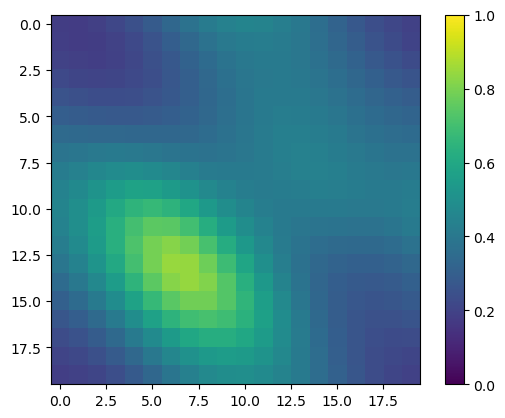

In [39]:
mag_u_top = abs(u_top)**2
mag_u_top = mag_u_top.reshape(20,20, 2, 8, 2)
mag_u_top.shape
col_lat = np.sum([ mag_u_top[..., i, :] for i in high_E_sites], axis=(0,-1))

plt.imshow(col_lat[..., 0], vmin=0, vmax=1)
plt.colorbar()

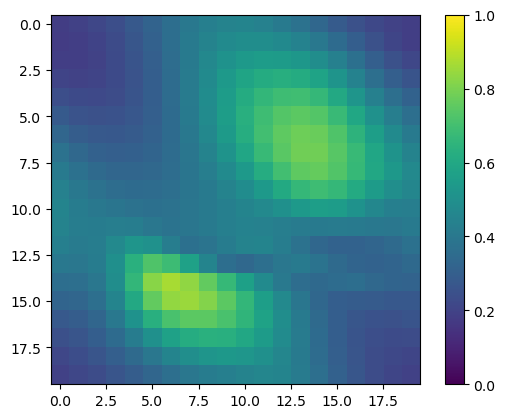

In [40]:
plt.imshow(col_lat[..., 1], vmin=0, vmax=1)
plt.colorbar()

In [41]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 1000, report=False)

# Actual eigenstates and eigenenergies
evals, evecs = model.solve_ham(k_vec, return_eigvecs=True)
n_eigs = evecs.shape[-2]

# Reduced Wannier interpolated energies and states
interp_energies_triv, interp_unk_triv = WF.interp_energies(k_vec, ret_eigvecs=True)

# Complementary subspace interpolated energies and states
interp_energies_top, interp_unk_top = WF.interp_energies(k_vec, u_tilde=u_top, ret_eigvecs=True) 

In [42]:
interp_unk_top.shape

(1000, 2, 16)

In [43]:
interp_unk_top = interp_unk_top.reshape(interp_unk_top.shape[0], interp_unk_top.shape[1], interp_unk_top.shape[2]//2, 2)
interp_unk_triv = interp_unk_triv.reshape(interp_unk_triv.shape[0], interp_unk_triv.shape[1], interp_unk_triv.shape[2]//2, 2)

In [45]:
H_k = WF.get_Bloch_Ham()
new_shape = H_k.shape[:-4] + (2*n_orb, 2*n_orb)
H_k = H_k.reshape(*new_shape)

In [46]:
H_top_k = P_top @ H_k @ P_top
H_triv_k = P_tilde @ H_k @ P_tilde

eigvals_top, eigvecs_top = np.linalg.eigh(H_top_k)
eigvecs_top = np.swapaxes(eigvecs_top, -1, -2)

eigvals_triv, eigvecs_triv = np.linalg.eigh(H_triv_k)
eigvecs_triv = np.swapaxes(eigvecs_triv, -1, -2)

print(eigvals_top.shape)
print(eigvals_top[0,4])
print(eigvals_triv[0,4])

# eigvecs = np.einsum('...ij, ...ik->...kj', u_tilde, eigvecs)

(20, 20, 16)
[-1.70090567e+00 -1.46217678e+00 -2.87996631e-16 -2.20565549e-16
 -9.21982503e-17 -8.13206209e-17 -3.17901298e-17 -2.09670766e-17
 -6.93521602e-18 -2.04417052e-18  4.30128176e-18  6.71804418e-18
  1.68794222e-17  3.32702125e-17  6.37006751e-17  4.41849210e-16]
[-3.04507864e+00 -2.80051995e+00 -2.00550179e+00 -1.93845468e+00
 -1.49722154e+00 -1.33286037e+00 -1.07680148e-15 -5.43497006e-16
 -4.34590836e-16 -1.59635361e-16 -9.02305783e-17 -5.28306469e-17
  8.67632355e-17  1.73893180e-16  3.25482269e-16  5.40226070e-16]


In [47]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 800, report=False)

# Actual eigenstates and eigenenergies
evals, evecs = model.solve_ham(k_vec, return_eigvecs=True)
n_eigs = evecs.shape[-2]

In [48]:
np.fft.ifft(eigvecs_triv).shape

(20, 20, 16, 16)

In [49]:
k_vec[-1]

array([0.5, 0.5])

In [50]:
from itertools import product

k_mesh = WF.k_mesh.square_mesh
k_idx_arr = WF.k_mesh.idx_arr
nks = WF.k_mesh.nks
Nk = np.prod([nks])

supercell = list(product(*[range(-int((nk-nk%2)/2), int((nk-nk%2)/2)) for nk in nks]))
phase_path = np.exp(-1j * 2 * np.pi * k_vec @ np.array(supercell).T)
phase_mesh = np.exp(1j * 2 * np.pi * k_mesh @ np.array(supercell).T)

eval_R_top = np.sum(eigvals_top[..., None, :] * phase_mesh[..., None], axis=(0,1)) / Nk
eval_R_triv = np.sum(eigvals_triv[..., None, :] * phase_mesh[..., None], axis=(0,1)) / Nk
evecs_R_top = np.sum(eigvecs_top[..., None, :, :] * phase_mesh[..., None, None], axis=(0,1)) / Nk
evecs_R_triv = np.sum(eigvecs_triv[..., None, :, :] * phase_mesh[..., None, None], axis=(0,1)) / Nk

evals_k_top = np.sum(eval_R_top[None, :, :] * phase_path[..., None], axis=1)
evals_k_triv = np.sum(eval_R_triv[None, :, :] * phase_path[... ,None], axis=1) 
evecs_k_top = np.sum(evecs_R_top[None, :, :, :] * phase_path[..., None, None], axis=1)
evecs_k_triv = np.sum(evecs_R_triv[None, :, :, :] * phase_path[..., None, None], axis=1)

# phase_path = phase_path.reshape(phase_path.shape[0], *nks)
evals_k_top = np.sum(eval_R_top[None, :, :] * phase_path[..., None], axis=(1))
evals_k_triv = np.sum(eval_R_triv[None, :, :] * phase_path[..., None], axis=(1))
evecs_k_top = np.sum(evecs_R_top[None, :, :, :] * phase_path[..., None, None], axis=(1))
evecs_k_triv = np.sum(evecs_R_triv[None, :, :, :] * phase_path[..., None, None], axis=(1))

evals_top_path = evals_k_top[:, :2].real
evals_triv_path = evals_k_triv[:, :6].real

evecs_top_path = evecs_k_top[:, :2, :]
evecs_triv_path = evecs_k_triv[:, :6, :]

evecs_top_path /= np.linalg.norm(evecs_top_path, axis=-1, keepdims=True)
evecs_triv_path /= np.linalg.norm(evecs_triv_path, axis=-1, keepdims=True)

# evecs_k_top /= np.linalg.norm(evecs_k_top, axis=-1, keepdims=True)
# evecs_k_triv /= np.linalg.norm(evecs_k_triv, axis=-1, keepdims=True)

# evals_top_path = evals_k_top
# evecs_top_path = evecs_k_top

# evals_triv_path = evals_k_triv
# evecs_triv_path = evecs_k_triv

In [51]:
# evals_top_path = evals_top_path[:, :2].real
# evals_triv_path = evals_triv_path[:, :6].real

evecs_top_path = evecs_top_path.reshape(evecs_top_path.shape[0], evecs_top_path.shape[1], evecs_top_path.shape[2]//2, 2)
evecs_triv_path = evecs_triv_path.reshape(evecs_triv_path.shape[0], evecs_triv_path.shape[1], evecs_triv_path.shape[2]//2, 2)

(800, 2, 8, 2) (800, 2)


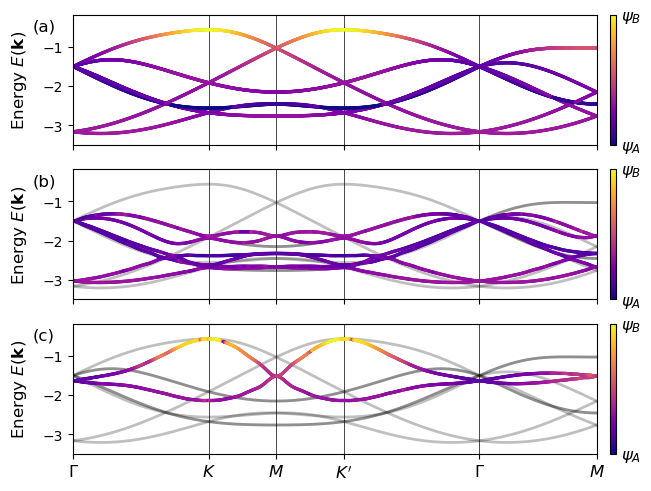

In [52]:
fig, axs = plt.subplots(3, 1, sharex=True, constrained_layout=True)

############# subplot a ####################
     
# Actual bands
wt = abs(evecs)**2
col = np.sum([ wt[..., i, :] for i in high_E_sites], axis=(0,-1))
for n in range(evals.shape[-1]):
    axs[0].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0)

    scat = axs[0].scatter(
        k_dist, evals[:, n], c=col[:, n], 
        cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)

cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_B$', r'$\psi_A$'], size=12)
# cbar.ax.set_yticklabels([])
cbar.ax.tick_params(size=0) 

axs[0].set_xlim(0, k_node[-1])
for n in range(len(k_node)):
    axs[0].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)

axs[0].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[0].yaxis.labelpad = 10
axs[0].set_ylim(-3.5, -0.18)

axs[0].text(-.1, -0.6, '(a)', size=12)

############# subplot b ####################

# Actual bands
for n in range(evals.shape[-1]):
    axs[1].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

# Reduced bands
wt = abs(evecs_triv_path)**2
col = np.sum([ wt[..., i, :] for i in high_E_sites], axis=(0,-1))
for n in range(evals_triv_path.shape[-1]):
    scat = axs[1].scatter(
            k_dist, evals_triv_path[:, n], c=col[:, n], 
            cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)

cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_B$', r'$\psi_A$'], size=12)
# cbar.ax.set_yticklabels([])
cbar.ax.tick_params(size=0) 

axs[1].set_xlim(0, k_node[-1])
axs[1].set_xticks([])
for n in range(len(k_node)):
    axs[1].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)

axs[1].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[1].yaxis.labelpad = 10
axs[1].set_ylim(-3.5, -0.18)

axs[1].text(-.1, -0.6, '(b)', size=12)

############# subplot c ####################

# Actual bands
for n in range(evals.shape[-1]):
    axs[2].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

# Complementary bands
wt = abs(evecs_top_path)**2
col = np.sum([ wt[..., i, :] for i in high_E_sites], axis=(0,-1))
print(wt.shape, col.shape)
# col = np.sum(wt[..., 0], axis=(-1))

for n in range(evals_top_path.shape[-1]):
    axs[2].plot(k_dist, evals_top_path[:, n], c='k', lw=2, zorder=0)
    scat = axs[2].scatter(
            k_dist, evals_top_path[:, n], c=col[:, n], 
            cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)

cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_B$', r'$\psi_A$'], size=12)
# cbar.ax.set_yticklabels([])
cbar.ax.tick_params(size=0) 

axs[2].set_xlim(0, k_node[-1])
axs[2].set_xticks(k_node)
for n in range(len(k_node)):
    axs[2].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)
if k_label is not None:
    axs[2].set_xticklabels(k_label, size=12)

axs[2].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[2].yaxis.labelpad = 10
axs[2].set_ylim(-3.5, -0.18)

axs[2].text(-.1, -0.6, '(c)', size=12)

# plt.subplots_adjust(top=.97, left=0.13, bottom=0.07, right=1.06, hspace=0.07)
plt.savefig(f"figures/fig13_interp_all_bands_{save_sfx}.png", dpi=700)